# End to end DLA prediction, localization, and column density measurement

![title](html/sightline.png)

This demo utilizes pretrained convolutional neural network classification and regression models. Predictions are executed and visualized at each step in the pipeline for DLA detection, localization, and column density measurement.

This demo has no dependency other than the python files included with it, it will download the necessary FITS files, or you can specify a directory for it to load them from, you specify the plate, mjd, and fiber below.

In [1]:
# Enter the plate mjd and fiber of one or more SDSS 12 fits files, the re-run all cells
# The FITS files will be downloaded from the SDSS site and require internet access (and that the SDSS site is up)

LOCAL_FITS_FILES_LOCATION = "../BOSS_dat_all"

PLATE_MJD_FIBER = [
    [4637,55616,522],   # Good example (DR9:4091/20.494 +/- 0.069)
    [5002,55710,598],   # Good example (DR9:4990/20.885 +/- 0.104)
#     [5010,55748,888],   # No DLA example, localization off, but NO_DLA classification accurate
    [4565,55591,868],   # Multiple DLA detection, Minor peak detection issue (DR9:5029/20.088 +/- 0.062)
    [4091,55498,785],   # Misclassified but localization model finds DLA w/ minor issues (DR9:3856/20.685 +/- 0.113)
    [4568,55600,884],   # Left side issue example; bad central wavelength peaks calculations (DR9:3762/20.070 +/- 0.105)
]

# Results

The following 5 components are provide for each plate-mjd-fiber:

- 1) Print the central wavelength and column density measure of each DLA detected in the sightline.
- 2) Plot of the full sightline in rest frame
- 3) Plot of the DLA range 960A to 1216A in rest frame
- 4) Plot of the localization confidence across the sightline (redshift matches graph 2)
- 5) Plot of column density values measured at each point around the DLA (these values are averaged to arrive at the final printed value above)

In [2]:
%load_ext autoreload
import sys
sys.path.append('./src')

/usr/lib/python2.7/dist-packages/matplotlib/__init__.py:1352: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)



Classified 4637-55616-522 as HAS_DLA with confidence of 99% (where 50% = guess, 100% = confident)


ValueError: Cannot feed value of shape (1614, 392) for Tensor u'Placeholder:0', which has shape '(?, 400)'

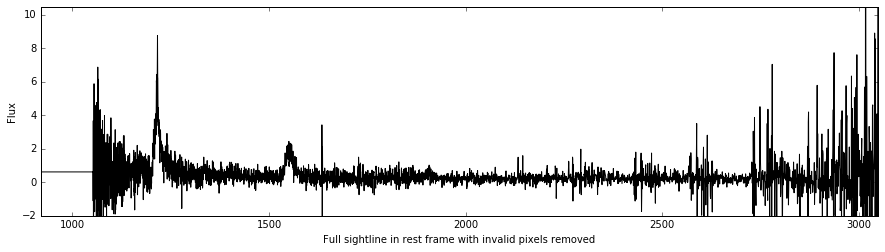

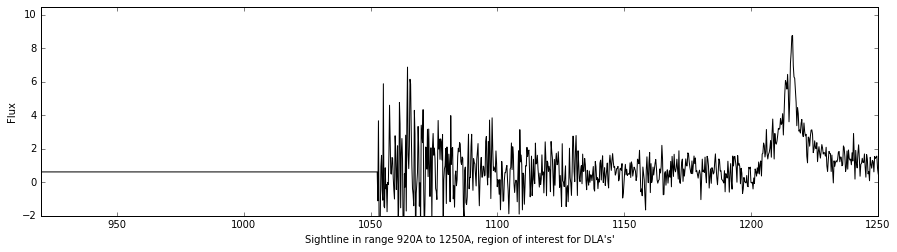

In [11]:
%autoreload
import imp, json, os, urllib, numpy as np
from classification_model import predictions_ann as predictions_ann_c1
from localize_model import predictions_ann as predictions_ann_c2, predictions_to_central_wavelength
from density_model import predictions_ann as predictions_ann_r1
from data_loader import normalize, read_fits_file, scan_flux_sample, \
                        scan_flux_about_central_wavelength, get_raw_data_for_classification, REST_RANGE
from DataSet import DataSet
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})

MODEL_CHECKPOINT_C1 = "models/classification_model"
MODEL_CHECKPOINT_C2 = "models/localize_model"
MODEL_CHECKPOINT_R1 = "models/density_model"
# REST_RANGE = [920.0, 1334.0]


def plot(y, x_label="Rest Frame", y_label="Flux", x=None, ylim=[-2,12], xlim=None, z_qso=None):
    fig, ax = plt.subplots(figsize=(15, 3.75))
    if x is None:
        ax.plot(y, '-k')
    else:
        ax.plot(x,y,'-k')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    return fig, ax
    
def load_data(plate,mjd,fiber):
    # Download the file
    (data1, z_qso) = read_fits_file(plate, mjd, fiber, fits_base_dir=LOCAL_FITS_FILES_LOCATION, 
                                    download_if_notfound=False)
    
    # Classification 1 dataset
    classification1 = get_raw_data_for_classification(data1, z_qso)
    
    # Classification 2 dataset
    flux, offsets = scan_flux_sample(normalize(data1, z_qso), data1['loglam'], z_qso, -1, -1, 
                            plate, mjd, fiber, -1, -1, exclude_positive_samples=False, 
                            kernel=400, stride=1, pos_sample_kernel_percent=0.3)
    
    return data1, z_qso, DataSet(classification1), DataSet(flux), offsets

    
for pmf in PLATE_MJD_FIBER:
    # Download fits file and create a custom DataSet object
    data1, z_qso, c1_dataset, c2_dataset, c2_offsets = load_data(pmf[0],pmf[1],pmf[2])
    lam = 10.0**data1['loglam']
    lam_rest = lam/(1.0 + z_qso)
    ix_dla_range = np.logical_and(lam_rest >= REST_RANGE[0], lam_rest <= REST_RANGE[1])
    y_plot_range = np.mean(data1['flux'][np.logical_not(np.isnan(data1['flux']))]) + 10
    
    # Classification model - Load model hyperparameter file & Generate predictions
    with open(MODEL_CHECKPOINT_C1+"_hyperparams.json", 'r') as fp:
        hyperparameters_c1 = json.load(fp)
        prediction, confidence = predictions_ann_c1(hyperparameters_c1, c1_dataset.fluxes,
                                                    c1_dataset.labels, MODEL_CHECKPOINT_C1)
    
    # Print results
    print("\nClassified %d-%d-%d as %s with confidence of %d%% (where 50%% = guess, 100%% = confident)"% \
          (pmf[0],pmf[1],pmf[2], "HAS_DLA" if round(prediction)==1.0 else "NO_DLA", int((abs(0.5-confidence)+0.5)*100)))
    
    # Plot full sightline
    plot(data1['flux'], x_label="Full sightline in rest frame with invalid pixels removed", 
         y_label='Flux', x=lam_rest, xlim=[REST_RANGE[0],lam_rest[-1]], ylim=[-2,y_plot_range])
    
    # Plot DLA range of sightline
    (fig_sight, ax_sight) = plot(data1['flux'], x_label="Sightline in range %dA to 1250A, region of interest for DLA's'"
                                 % REST_RANGE[0], y_label='Flux', x=lam_rest,
                                 xlim=[REST_RANGE[0],1250], ylim=[-2,y_plot_range])
    
    # Localization model - Load model hyperparameter file
    with open(MODEL_CHECKPOINT_C2+"_hyperparams.json", 'r') as fp:
        hyperparameters_c2 = json.load(fp)
        loc_pred, loc_conf = predictions_ann_c2(hyperparameters_c2, c2_dataset.fluxes, 
                                                c2_dataset.labels, c2_offsets, MODEL_CHECKPOINT_C2)

    (fig, ax) = plot(loc_conf, ylim=[0,1], x=lam_rest[ix_dla_range], xlim=[REST_RANGE[0],1250], 
                     z_qso=z_qso, x_label="DLA Localization confidence & localization prediction(s)")
    
    # Identify peaks from classification-2 results
    (peaks, peaks_uncentered, smoothed_sample, ixs_left, ixs_right) = predictions_to_central_wavelength(loc_conf, 1, 50, 300)[0]
#     print(np.shape(peaks), np.shape(peaks_uncentered), np.shape(loc_conf), np.shape(smoothed_sample))
    ax.plot(lam_rest[ix_dla_range], smoothed_sample, color='blue', alpha=0.9)

    for peak, peak_uncentered, ix_left, ix_right in zip(peaks, peaks_uncentered, ixs_left, ixs_right):
        peak_lam_rest = lam_rest[ix_dla_range][peak]
        if peak_lam_rest > 1250 or peak_lam_rest < REST_RANGE[0]:
            print(" > Excluded peak: %0.0fA" % peak_lam_rest)
            continue

        # Plot peak '+' markers
        ax.plot(lam_rest[ix_dla_range][peak_uncentered], loc_conf[peak_uncentered], '+', mew=3, ms=7, color='red', alpha=1)
        ax.plot(lam_rest[ix_dla_range][peak], smoothed_sample[peak], '+', mew=7, ms=15, color='blue', alpha=0.9)
        ax.plot(lam_rest[ix_dla_range][ix_left], loc_conf[peak_uncentered]/2, '+', mew=3, ms=7, color='orange', alpha=1)
        ax.plot(lam_rest[ix_dla_range][ix_right], loc_conf[peak_uncentered]/2, '+', mew=3, ms=7, color='orange', alpha=1)

        # Column density estimate
        density_data = DataSet(scan_flux_about_central_wavelength(data1['flux'], data1['loglam'], z_qso, 
                                                                  peak_lam_rest*(1+z_qso), 0, 80, 0, 0, 0, 400, 0.2))

        with open(MODEL_CHECKPOINT_R1+"_hyperparams.json", 'r') as fp:
            hyperparameters_r1 = json.load(fp)
            density_pred = predictions_ann_r1(hyperparameters_r1, density_data.fluxes, 
                                              density_data.labels, MODEL_CHECKPOINT_R1)
            density_pred_np = np.array(density_pred)

        mean_col_density_prediction = np.mean(density_pred_np)
        
        # Bar plot
        fig_b, ax_b = plt.subplots(figsize=(15, 3.75))
        ax_b.bar(np.arange(0,np.shape(density_pred_np)[1]), density_pred_np[0,:], 0.25)
        ax_b.set_xlabel("Individual Column Density estimates for peak @ %0.0fA, +/- 0.3 of mean. " % (peak_lam_rest) + 
                        "Mean: %0.3f - Median: %0.3f - Stddev: %0.3f" % (np.mean(density_pred_np), 
                        np.median(density_pred_np), np.std(density_pred_np)))
        plt.ylim([mean_col_density_prediction-0.3,mean_col_density_prediction+0.3])
        ax_b.plot(np.arange(0,np.shape(density_pred_np)[1]), 
                np.ones((np.shape(density_pred_np)[1],),np.float32)*mean_col_density_prediction)

        # Sightline plot transparent marker boxes
        ax_sight.fill_between(lam_rest[ix_dla_range][peak-10:peak+10], y_plot_range, -2, color='gray', lw=0, alpha=0.1)
        ax_sight.fill_between(lam_rest[ix_dla_range][peak-30:peak+30], y_plot_range, -2, color='gray', lw=0, alpha=0.1)
        ax_sight.fill_between(lam_rest[ix_dla_range][peak-50:peak+50], y_plot_range, -2, color='gray', lw=0, alpha=0.1)
        ax_sight.fill_between(lam_rest[ix_dla_range][peak-70:peak+70], y_plot_range, -2, color='gray', lw=0, alpha=0.1)
        
        print(" > DLA central wavelength at: %0.0fA rest / %0.0fA spectrum w/ confidence %0.2f, has Column Density: %0.3f"
              %(peak_lam_rest, peak_lam_rest*(1+z_qso), smoothed_sample[peak], mean_col_density_prediction))
            
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(['DLA pred','Smoothed pred','Original peak','Recentered peak','Centering points'], bbox_to_anchor=(0.25, 1.1))
        
    # Print URL
    print(" > http://dr12.sdss3.org/spectrumDetail?plateid=%d&mjd=%d&fiber=%d"%(pmf[0],pmf[1],pmf[2]))
